In [73]:
import pandas as pd
import numpy as np
import pywt # 小波分析
from scipy import stats 
import scipy.fftpack as fftpack # 希尔伯特变换

import itertools
import datetime as dt
from tqdm import *
from jqdata import *
import talib

from sklearn import preprocessing
from sklearn import svm   

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.gridspec as mg # 不规则子图
pd.plotting.register_matplotlib_converters()

# 设置字体 用来正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['font.family']='serif' # pd.plot中文
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

In [2]:
# 回测模块
import datetime
import numpy as np
import pandas as pd
import time
import copy
import pickle
from jqdata import *
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


# 定义类'参数分析'
class parameter_analysis(object):
    
    # 定义函数中不同的变量
    def __init__(self, algorithm_id=None):
        self.algorithm_id = algorithm_id            # 回测id
        
        self.params_df = pd.DataFrame()             # 回测中所有调参备选值的内容，列名字为对应修改面两名称，对应回测中的 g.XXXX
        self.results = {}                           # 回测结果的回报率，key 为 params_df 的行序号，value 为
        self.evaluations = {}                       # 回测结果的各项指标，key 为 params_df 的行序号，value 为一个 dataframe
        self.backtest_ids = {}                      # 回测结果的 id
        
        # 新加入的基准的回测结果 id，可以默认为空 ''，则使用回测中设定的基准
        self.benchmark_id = 'f16629492d6b6f4040b2546262782c78'                      
        
        self.benchmark_returns = []                 # 新加入的基准的回测回报率
        self.returns = {}                           # 记录所有回报率
        self.excess_returns = {}                    # 记录超额收益率
        self.log_returns = {}                       # 记录收益率的 log 值
        self.log_excess_returns = {}                # 记录超额收益的 log 值
        self.dates = []                             # 回测对应的所有日期
        self.excess_max_drawdown = {}               # 计算超额收益的最大回撤
        self.excess_annual_return = {}              # 计算超额收益率的年化指标
        self.evaluations_df = pd.DataFrame()        # 记录各项回测指标，除日回报率外
        self.failed_list= []
    
    # 定义排队运行多参数回测函数
    def run_backtest(self,                          #
                     algorithm_id=None,             # 回测策略id
                     running_max=10,                # 回测中同时巡行最大回测数量
                     start_date='2006-01-01',       # 回测的起始日期
                     end_date='2016-11-30',         # 回测的结束日期
                     frequency='day',               # 回测的运行频率
                     initial_cash='1000000',        # 回测的初始持仓金额
                     param_names=[],                # 回测中调整参数涉及的变量
                     param_values=[],               # 回测中每个变量的备选参数值
                     python_version = 2,            # 回测的python版本
                     use_credit =False              # 是否允许消耗积分继续回测
                     ):
        # 当此处回测策略的 id 没有给出时，调用类输入的策略 id
        if algorithm_id == None: algorithm_id=self.algorithm_id
        
        # 生成所有参数组合并加载到 df 中
        # 包含了不同参数具体备选值的排列组合中一组参数的 tuple 的 list
        param_combinations = list(itertools.product(*param_values))
        # 生成一个 dataframe， 对应的列为每个调参的变量，每个值为调参对应的备选值
        to_run_df = pd.DataFrame(param_combinations,dtype='object')
        # 修改列名称为调参变量的名字
        to_run_df.columns = param_names
        
        # 设定运行起始时间和保存格式
        start = time.time()
        # 记录结束的运行回测
        finished_backtests = {}
        # 记录运行中的回测
        running_backtests = {}
        # 计数器
        pointer = 0
        # 总运行回测数目，等于排列组合中的元素个数
        total_backtest_num = len(param_combinations)
        # 记录回测结果的回报率
        all_results = {}
        # 记录回测结果的各项指标
        all_evaluations = {}
        
        # 在运行开始时显示
        print(('【已完成|运行中|待运行】:'), end=' ') 
        # 当运行回测开始后，如果没有全部运行完全的话：
        while len(finished_backtests)<total_backtest_num:
            # 显示运行、完成和待运行的回测个数
            print(('[%s|%s|%s].' % (len(finished_backtests), 
                                   len(running_backtests), 
                                   (total_backtest_num-len(finished_backtests)-len(running_backtests)) )), end=' ')
            # 记录当前运行中的空位数量
            to_run = min(running_max-len(running_backtests), total_backtest_num-len(running_backtests)-len(finished_backtests))
            # 把可用的空位进行跑回测
            for i in range(pointer, pointer+to_run):
                # 备选的参数排列组合的 df 中第 i 行变成 dict，每个 key 为列名字，value 为 df 中对应的值
                params = to_run_df.iloc[i].to_dict()
                # 记录策略回测结果的 id，调整参数 extras 使用 params 的内容
                backtest = create_backtest(algorithm_id = algorithm_id,
                                           start_date = start_date, 
                                           end_date = end_date, 
                                           frequency = frequency, 
                                           initial_cash = initial_cash, 
                                           extras = params, 
                                           # 再回测中把改参数的结果起一个名字，包含了所有涉及的变量参数值
                                           name = str(params),
                                           python_version = python_version,
                                           use_credit = use_credit
                                           )
                # 记录运行中 i 回测的回测 id
                running_backtests[i] = backtest
            # 计数器计数运行完的数量    
            pointer = pointer+to_run
            
            # 获取回测结果
            failed = []
            finished = []
            # 对于运行中的回测，key 为 to_run_df 中所有排列组合中的序数
            for key in list(running_backtests.keys()):
                # 研究调用回测的结果，running_backtests[key] 为运行中保存的结果 id
                back_id = running_backtests[key]
                bt = get_backtest(back_id)
                # 获得运行回测结果的状态，成功和失败都需要运行结束后返回，如果没有返回则运行没有结束
                status = bt.get_status()
                # 当运行回测失败
                if status == 'failed':
                    # 失败 list 中记录对应的回测结果 id
                    print('')
                    print(('回测失败 : https://www.joinquant.com/algorithm/backtest/detail?backtestId='+back_id))
                    failed.append(key) 
                # 当运行回测成功时
                elif status == 'done':
                    # 成功 list 记录对应的回测结果 id，finish 仅记录运行成功的
                    finished.append(key)
                    # 回测回报率记录对应回测的回报率 dict， key to_run_df 中所有排列组合中的序数， value 为回报率的 dict
                    # 每个 value 一个 list 每个对象为一个包含时间、日回报率和基准回报率的 dict
                    all_results[key] = bt.get_results()
                    # 回测回报率记录对应回测结果指标 dict， key to_run_df 中所有排列组合中的序数， value 为回测结果指标的 dataframe
                    all_evaluations[key] = bt.get_risk()
            # 记录运行中回测结果 id 的 list 中删除失败的运行
            for key in failed:
                finished_backtests[key] = running_backtests.pop(key)
            # 在结束回测结果 dict 中记录运行成功的回测结果 id，同时在运行中的记录中删除该回测
            for key in finished:
                finished_backtests[key] = running_backtests.pop(key)
#                 print (finished_backtests)
            # 当一组同时运行的回测结束时报告时间
            if len(finished_backtests) != 0 and len(finished_backtests) % running_max == 0 and to_run !=0:
                # 记录当时时间
                middle = time.time()
                # 计算剩余时间，假设没工作量时间相等的话
                remain_time = (middle - start) * (total_backtest_num - len(finished_backtests)) / len(finished_backtests)
                # print 当前运行时间
                print(('[已用%s时,尚余%s时,请不要关闭浏览器].' % (str(round((middle - start) / 60.0 / 60.0,3)), 
                                          str(round(remain_time / 60.0 / 60.0,3)))), end=' ')
            self.failed_list  += failed
            # 5秒钟后再跑一下
            time.sleep(5) 
        # 记录结束时间
        end = time.time() 
        print('')
        print(('【回测完成】总用时：%s秒(即%s小时)。' % (str(int(end-start)), 
                                           str(round((end-start)/60.0/60.0,2)))), end=' ')
#         print (to_run_df,all_results,all_evaluations,finished_backtests)
        # 对应修改类内部对应
#         to_run_df = {key:value for key,value in returns.items() if key not in faild}
        self.params_df = to_run_df
#         all_results = {key:value for key,value in all_results.items() if key not in faild}
        self.results = all_results
#         all_evaluations = {key:value for key,value in all_evaluations.items() if key not in faild}
        self.evaluations = all_evaluations
#         finished_backtests = {key:value for key,value in finished_backtests.items() if key not in faild}
        self.backtest_ids = finished_backtests

        
    #7 最大回撤计算方法
    def find_max_drawdown(self, returns):
        # 定义最大回撤的变量
        result = 0
        # 记录最高的回报率点
        historical_return = 0
        # 遍历所有日期
        for i in range(len(returns)):
            # 最高回报率记录
            historical_return = max(historical_return, returns[i])
            # 最大回撤记录
            drawdown = 1-(returns[i] + 1) / (historical_return + 1)
            # 记录最大回撤
            result = max(drawdown, result)
        # 返回最大回撤值
        return result

    # log 收益、新基准下超额收益和相对与新基准的最大回撤
    def organize_backtest_results(self, benchmark_id=None):
        # 若新基准的回测结果 id 没给出
        if benchmark_id==None:
            # 使用默认的基准回报率，默认的基准在回测策略中设定
            self.benchmark_returns = [x['benchmark_returns'] for x in self.results[0]]
        # 当新基准指标给出后    
        else:
            # 基准使用新加入的基准回测结果
            self.benchmark_returns = [x['returns'] for x in get_backtest(benchmark_id).get_results()]
        # 回测日期为结果中记录的第一项对应的日期
        self.dates = [x['time'] for x in self.results[0]]
        
        # 对应每个回测在所有备选回测中的顺序 （key），生成新数据
        # 由 {key：{u'benchmark_returns': 0.022480100091729405,
        #           u'returns': 0.03184566700000002,
        #           u'time': u'2006-02-14'}} 格式转化为：
        # {key: []} 格式，其中 list 为对应 date 的一个回报率 list
        for key in list(self.results.keys()):
            self.returns[key] = [x['returns'] for x in self.results[key]]
        # 生成对于基准（或新基准）的超额收益率
        for key in list(self.results.keys()):
            self.excess_returns[key] = [(x+1)/(y+1)-1 for (x,y) in zip(self.returns[key], self.benchmark_returns)]
        # 生成 log 形式的收益率
        for key in list(self.results.keys()):
            self.log_returns[key] = [log(x+1) for x in self.returns[key]]
        # 生成超额收益率的 log 形式
        for key in list(self.results.keys()):
            self.log_excess_returns[key] = [log(x+1) for x in self.excess_returns[key]]
        # 生成超额收益率的最大回撤
        for key in list(self.results.keys()):
            self.excess_max_drawdown[key] = self.find_max_drawdown(self.excess_returns[key])
        # 生成年化超额收益率
        for key in list(self.results.keys()):
            self.excess_annual_return[key] = (self.excess_returns[key][-1]+1)**(252./float(len(self.dates)))-1
        # 把调参数据中的参数组合 df 与对应结果的 df 进行合并
        self.evaluations_df = pd.concat([self.params_df, pd.DataFrame(self.evaluations).T], axis=1)
#         self.evaluations_df = 

    # 获取最总分析数据，调用排队回测函数和数据整理的函数    
    def get_backtest_data(self,
                          algorithm_id=None,                         # 回测策略id
                          benchmark_id=None,                         # 新基准回测结果id
                          file_name='results.pkl',                   # 保存结果的 pickle 文件名字
                          running_max=10,                            # 最大同时运行回测数量
                          start_date='2006-01-01',                   # 回测开始时间
                          end_date='2016-11-30',                     # 回测结束日期
                          frequency='day',                           # 回测的运行频率
                          initial_cash='1000000',                    # 回测初始持仓资金
                          param_names=[],                            # 回测需要测试的变量
                          param_values=[],                           # 对应每个变量的备选参数
                          python_version = 2,
                          use_credit = False
                          ):
        # 调运排队回测函数，传递对应参数
        self.run_backtest(algorithm_id=algorithm_id,
                          running_max=running_max,
                          start_date=start_date,
                          end_date=end_date,
                          frequency=frequency,
                          initial_cash=initial_cash,
                          param_names=param_names,
                          param_values=param_values,
                          python_version = python_version,
                          use_credit = use_credit,
                          )
        # 回测结果指标中加入 log 收益率和超额收益率等指标
        self.organize_backtest_results(benchmark_id)
        # 生成 dict 保存所有结果。
        results = {'returns':self.returns,
                   'excess_returns':self.excess_returns,
                   'log_returns':self.log_returns,
                   'log_excess_returns':self.log_excess_returns,
                   'dates':self.dates,
                   'benchmark_returns':self.benchmark_returns,
                   'evaluations':self.evaluations,
                   'params_df':self.params_df,
                   'backtest_ids':self.backtest_ids,
                   'excess_max_drawdown':self.excess_max_drawdown,
                   'excess_annual_return':self.excess_annual_return,
                   'evaluations_df':self.evaluations_df,
                    "failed_list" : self.failed_list}
        # 保存 pickle 文件
        pickle_file = open(file_name, 'wb')
        pickle.dump(results, pickle_file)
        pickle_file.close()

    # 读取保存的 pickle 文件，赋予类中的对象名对应的保存内容    
    def read_backtest_data(self, file_name='results.pkl'):
        pickle_file = open(file_name, 'rb')
        results = pickle.load(pickle_file)
        self.returns = results['returns']
        self.excess_returns = results['excess_returns']
        self.log_returns = results['log_returns']
        self.log_excess_returns = results['log_excess_returns']
        self.dates = results['dates']
        self.benchmark_returns = results['benchmark_returns']
        self.evaluations = results['evaluations']
        self.params_df = results['params_df']
        self.backtest_ids = results['backtest_ids']
        self.excess_max_drawdown = results['excess_max_drawdown']
        self.excess_annual_return = results['excess_annual_return']
        self.evaluations_df = results['evaluations_df']
        self.failed_list =  results['failed_list']
    # 回报率折线图    
    def plot_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(list(range(len(self.returns[key]))), self.returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(list(range(len(self.benchmark_returns))), self.benchmark_returns, label='benchmark', c='k', linestyle='--') 
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.returns[0]))

    # 超额收益率图    
    def plot_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(list(range(len(self.excess_returns[key]))), self.excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(list(range(len(self.benchmark_returns))), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('excess returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.excess_returns[0]))
        
    # log回报率图    
    def plot_log_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(list(range(len(self.log_returns[key]))), self.log_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(list(range(len(self.benchmark_returns))), [log(x+1) for x in self.benchmark_returns], label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_returns[0]))
    
    # 超额收益率的 log 图
    def plot_log_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(list(range(len(self.log_excess_returns[key]))), self.log_excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(list(range(len(self.benchmark_returns))), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log excess returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_excess_returns[0]))

        
    # 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
    def get_eval4_bar(self, sort_by=[]): 
        
        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        indices = set(sorted_params.index)-set(self.failed_list)
        fig = plt.figure(figsize=(20,7))

        # 定义位置
        ax1 = fig.add_subplot(221)
        # 设定横轴为对应分位，纵轴为对应指标
        ax1.bar(list(range(len(indices))), 
                [self.evaluations[x]['algorithm_return'] for x in indices], 0.6, label = 'Algorithm_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax1.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax1.set_ylabel('Algorithm_return', fontsize=15)
        # 设置y标签样式
        ax1.set_yticklabels([str(x*100)+'% 'for x in ax1.get_yticks()])
        # 设置图片标题样式
        ax1.set_title("Strategy's of Algorithm_return performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax2 = fig.add_subplot(224)
        # 设定横轴为对应分位，纵轴为对应指标
        ax2.bar(list(range(len(indices))), 
                [self.evaluations[x]['max_drawdown'] for x in indices], 0.6, label = 'Max_drawdown')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax2.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax2.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax2.set_yticklabels([str(x*100)+'% 'for x in ax2.get_yticks()])
        # 设置图片标题样式
        ax2.set_title("Strategy's of Max_drawdown performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax3 = fig.add_subplot(223)
        # 设定横轴为对应分位，纵轴为对应指标
        ax3.bar(list(range(len(indices))),
                [self.evaluations[x]['sharpe'] for x in indices], 0.6, label = 'Sharpe')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax3.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax3.set_ylabel('Sharpe', fontsize=15)
        # 设置x标签样式
        ax3.set_yticklabels([str(x*100)+'% 'for x in ax3.get_yticks()])
        # 设置图片标题样式
        ax3.set_title("Strategy's of Sharpe performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax4 = fig.add_subplot(222)
        # 设定横轴为对应分位，纵轴为对应指标
        ax4.bar(list(range(len(indices))), 
                [self.evaluations[x]['algorithm_volatility'] for x in indices], 0.6, label = 'Algorithm_volatility')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax4.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax4.set_ylabel('Algorithm_volatility', fontsize=15)
        # 设置x标签样式
        ax4.set_yticklabels([str(x*100)+'% 'for x in ax4.get_yticks()])
        # 设置图片标题样式
        ax4.set_title("Strategy's of Algorithm_volatility performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))
        
    #14 年化回报和最大回撤，正负双色表示
    def get_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        indices = set(sorted_params.index)-set(self.failed_list)
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.evaluations[x]['max_drawdown'] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Max_drawdown', zorder=10)
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.evaluations[x]['annual_algo_return'] for x in indices], color = 'r', 
                     width = 0.6, label = 'Annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))


    #14 超额收益的年化回报和最大回撤
    # 加入新的benchmark后超额收益和
    def get_excess_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        indices = set(sorted_params.index)-set(self.failed_list)
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.excess_max_drawdown[x] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Excess_max_drawdown')
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.excess_annual_return[x] for x in indices], color = 'r', 
                     width = 0.6, label = 'Excess_annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度


# 一、小波分析

小波分析理论是目前科学界和工程界讨论和研究最多的课题之一，它包含了丰富的数学内容，又具有巨大的应用潜力。小波分析是在 Fourier 分析的基础上发展起来的，是调和分析近半个世纪以来的结晶。其基本思想是将一般函数（信号）表示为规范正交小波基的线性叠加，核心内容是小波变换。由于小波变换在时域和频域具有良好的局部化性质，能自动调整时、频窗口，以适应实际分析需要，因而已成为许多工程学科应用的有力工具。

小波分析属时频分析的一种，主要依据下面三步来实现(Python开源库pywt是专门做小波分析的库)：

1. Decomposition——将信号序列分解为N层小波   
2. Denoise——对于分解得到的小波，选择阈值并进行去噪处理(要注意的是不是对每个小波都要处理，一般选择几个进行处理)
3. Reconstruction——将去噪后的小波，和未处理的小波，重构得到处理后的信号   

**关于小波的选择及阈值处理的总结**

《量化投资：策略与技术》
>综合来看，dbN（即Daubechies系列小波）、 symN（Symlets系列小波）、coifN（Coiflet系列小波）都比较合适，并且对于股价序列等相对 比较平缓的序列可选择消失矩阶数稍高一点， 即对应小波序列N取4～8都是可以的。但对收益率数据， 因其奇异点密度非常大，消失矩不能高， 建议不要超过4，即db2 ～ db4比较恰当。

>对股票价格等数据而言，其信号频率较少地与噪声重叠因此可以选用sqtwolog和heursure准则，使去噪效果更明显。 
但对收益率这样的高频数据，尽量采用保守的 rigrsure 或 minimaxi 准则来确定阈值，以保留较多的信号。


《平安证券-量化择时选股系列报告二：水致清则鱼自现_小波分析与支持向量机择时研究》
>采用 Symlets小波 + rigrsure法选择阈值 + 软约束方法 对 上证指数进行的处理

《国信证券-基于小波分析和支持向量机的指数预测模型》
>采用 选择小波Daubechies小波系(db4)并确定分解层次为 4 层 + sqtwolog阀值估计准则 +软约束方法 对沪深300进行的处理

In [3]:
print('查看小波函数族：',pywt.families())
print('查看sym小波族下的所有函数：',pywt.wavelist(family='sym',kind='all'))
print('查看mode的所有方法:',pywt.Modes.modes)

查看小波函数族： ['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']
查看sym小波族下的所有函数： ['sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']
查看mode的所有方法: ['zero', 'constant', 'symmetric', 'periodic', 'smooth', 'periodization', 'reflect', 'antisymmetric', 'antireflect']


## 小波阈值处理

具体处理及确认方法见代码

In [3]:
# 信号去噪
class DenoisingThreshold(object):
    '''
    获取小波去噪的阈值
    1. CalSqtwolog 固定阈值准则(sqtwolog)
    2. CalRigrsure 无偏风险估计准则（rigrsure）
    3. CalMinmaxi 极小极大准则（ minimaxi）
    4. CalHeursure
    
    参考：https://wenku.baidu.com/view/63d62a818762caaedd33d463.html
    
    对股票价格等数据而言，其信号频率较少地与噪声重叠因此可以选用sqtwolog和heursure准则，使去噪效果更明显。 
    但对收益率这样的高频数据，尽量采用保守的 rigrsure 或 minimaxi 准则来确定阈值，以保留较多的信号。
    '''
    

    def __init__(self,signal: np.array):

        self.signal = signal

        self.N = len(signal)

    # 固定阈值准则(sqtwolog)
    @property
    def CalSqtwolog(self) -> float:

        return np.sqrt(2 * np.log(self.N))

   
    # 无偏风险估计准则（rigrsure）
    @property
    def CalRigrsure(self)->float:

        N = self.N
        signal = np.abs(self.signal)
        signal = np.sort(signal)
        signal = np.power(signal, 2)

        risk_j = np.zeros(N)

        for j in range(N):

            if j == 0:
                risk_j[j] = 1 + signal[N - 1]
            else:
                risk_j[j] = (N - 2 * j + (N - j) *
                             (signal[N - j]) + np.sum(signal[:j])) / N

        k = risk_j.argmin()

        return np.sqrt(signal[k])

    # 极小极大准则（ minimaxi）
    @property
    def CalMinmaxi(self)->float:
        
        if self.N > 32:
            # N>32 可以使用minmaxi阈值 反之则为0
            return 0.3936 + 0.1829 * (np.log(self.N) / np.log(2))
        
        else:
            
            return 0

    @property
    def GetCrit(self)->float:

        return np.sqrt(np.power(np.log(self.N) / np.log(2), 3) * 1 / self.N)

    @property
    def GetEta(self)->float:

        return (np.sum(np.abs(self.signal)**2) - self.N) / self.N
    
    #混合准则（heursure）
    @property
    def CalHeursure(self):

        if self.GetCrit > self.GetEta:

            #print('推荐使用sqtwolog阈值')
            return self.CalSqtwolog
            
        else:

            #print('推荐使用 Min(sqtwolog阈值,rigrsure阈值)')
            return min(self.CalRigrsure,self.CalSqtwolog)
            


In [18]:
# 数据获取
HS300 = get_price('000300.XSHG','2014-01-01','2020-05-31',fields='close',panel=False)
HS300.columns = ['HS300']
HS300.head()

,HS300
2014-01-02,2321.98
2014-01-03,2290.78
2014-01-06,2238.64
2014-01-07,2238.00
2014-01-08,2241.91


对HS300指数时间序列进行小波分解，小波函数选择为db4，分解层个数为4个，即一个主要趋势，和四个细节成分

In [19]:
res_4 = pywt.wavedec(HS300['HS300'].values,wavelet='db8',mode='smooth',level=4)    
#四个参数分别 对应 输入的信号 ，小波名称， 信号扩展模式， 分解阶次   
col_name = ['主趋势'] + [f'细节{i}' for i in range(1,5)]
res4_df = pd.DataFrame(res_4,index=col_name).T
res4_df.head()

,主趋势,细节1,细节2,细节3,细节4
0,32209.815891,1.514788e-12,7.673862e-13,3.852474e-13,6.383782e-14
1,30212.671446,-5.095912e-05,-3.509303e-06,6.758547e-02,-7.075012e+00
2,28215.527003,3.034437e-04,3.228442e-02,6.365657e-01,-7.822495e+00
3,26218.382487,-2.725954e-02,9.129420e-01,2.758817e+00,1.130505e+01
4,24221.234249,-2.053835e+00,6.577057e+00,2.580613e+01,4.474413e-01


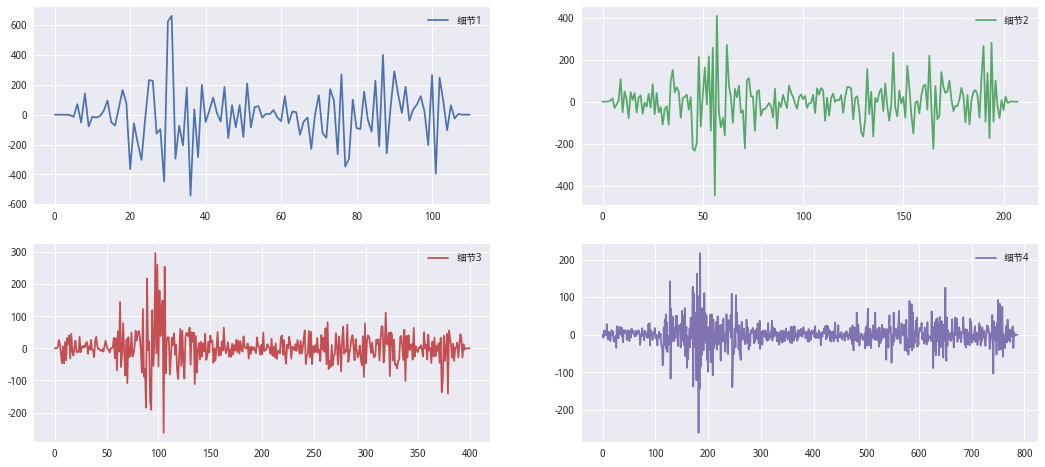

In [20]:
mpl.rcParams['font.family']='serif'
res4_df.iloc[:, 1:].plot(
    subplots=True, layout=(2, 2), figsize=(18, 8), sharex=False)
plt.show()

从上图可以看到，相对而言，细节3和4更像是高频的噪声信号，故对这两个细节进行阈值降噪处理。这里涉及到阈值选择的问题。
通常来说，阈值选择有：1、无偏风险估计阈值(rigrsure) 2、固定阈值 3、启发式阈值 4、极大极小阈值 这些方法，在这里选择rigsure方法来确定阈值

In [21]:
#对于高频的信号进行阈值处理
for j in [3,4]:     
    signal = res_4[j]
    threshold = DenoisingThreshold(signal).CalRigrsure 
    res_4[j] = pywt.threshold(signal, threshold, 'soft')
rec_hs = pywt.waverec(res_4, 'db8')

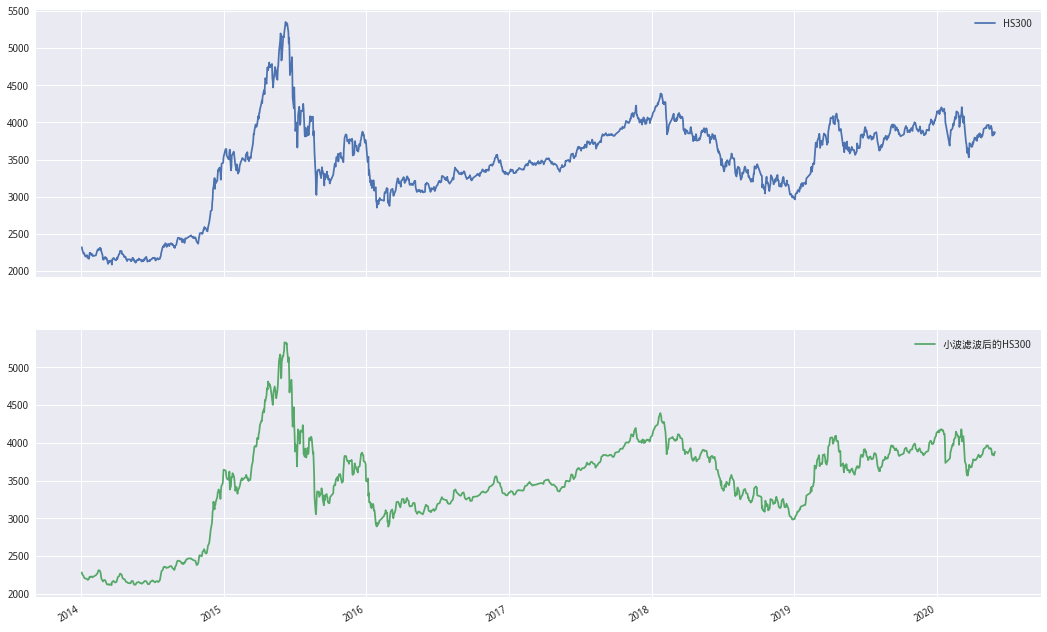

In [22]:
## 为什么小波重构后的序列 和 原序列的长度 存在差异呢？？？
HS300['小波滤波后的HS300'] = rec_hs[1:]

HS300.plot(subplots=True,figsize=(18,12))
plt.show()

可以看到小波处理后的序列，相对平滑一些，可能可以避免原序列中的噪声对模型预测带来的负面影响

# 二、HS300日涨跌预测
考虑利用7个指标(最近M日最高价，最近M日最低价，当日成交额在最近M日成交额中占比，过去M日涨跌幅，最近M日均价，MACD，RSI)，来对HS300的日涨跌进行预测。
本例中选择的分类器为SVM(核函数默认)。要说明的是，对于上述这些特征进行了标准化处理。M选择为5。查看了不同的模型训练窗宽下对HS300日涨跌的预测效果，汇总在res_svm_pred中。

In [5]:
HS300_data = get_price("000300.XSHG",
                     '2013-01-01',
                     '2020-05-31',
                     fields= "high,low,money,pre_close,close".split(','),
                     panel=False)

HS300_data = HS300_data.dropna()
HS300_data.head()

,high,low,money,pre_close,close
2013-01-04,2558.53,2498.89,9.557925e+10,2522.95,2524.41
2013-01-07,2545.97,2511.60,7.316751e+10,2524.41,2535.99
2013-01-08,2540.51,2502.49,7.649806e+10,2535.99,2525.33
2013-01-09,2534.24,2504.30,7.423360e+10,2525.33,2526.13
2013-01-10,2553.35,2513.73,7.115905e+10,2526.13,2530.57


In [ ]:
# 小波处理+svm滚动预测
class wavelet_svm_model(object):
    '''对数据进行建模预测
    --------------------
    输入参数：

        data:必须包含OHLC money
        M:train数据的滚动计算窗口
        window:滚动窗口 即T至T-window日 预测T-1至T-window日数据 预测T日数据
        wavelet\wavelet_mode:同pywt.wavedec的参数
        th_mode:阈值确认准则
        filter_num:需要过滤小波的细节组 比如(3,4)对三至四组进行过滤 为空则是1-4组全过滤 
        whether_wave_process:是否使用小波处理
    --------------------
    方法：
        wave_process:过滤阈值 采用固定阈值准则（sqtwolog）
        preprocess:生成训练用字段
            1. 近M日最高价
            2. 近M日最低价
            3. 成交额占比
            4. 近M日涨跌幅
            5. 近M日均价
            6. MACK
            7. RSI
            8. 预测字段
        standardization:归一化
        rolling_svm:使用svm滚动训练
    '''

    def __init__(self,
                 data: pd.DataFrame,
                 M: int,
                 window: int,
                 wavelet: str,
                 wavelet_mode: str,
                 th_mode: str,
                 filter_num=None,
                 whether_wave_process: bool = False):

        self.data = data
        self.__M = M
        self.__window = window
        self.__wavelet = wavelet
        self.__wavelet_mode = wavelet_mode
        self.__th_mode = th_mode
        self.__filter_num = filter_num
        self.__whether_wave_process = whether_wave_process

        self.__train_col = []  # 训练的字段

        self.train_df = pd.DataFrame()  # 储存训练数据
        self.predict_df = pd.DataFrame()  # 储存预测数据及真实Y

    def wave_process(self):
        '''对数据进行小波处理(可选)'''

        if self.__filter_num:

            a = self.__filter_num[0]
            b = self.__filter_num[1]

        else:

            a = 1
            b = 5

        data = self.data.copy()  # 复制

        for col in data.columns:

            denoised_ser = wave_transform(data[col],
                                          wavelet=self.__wavelet,
                                          wavelet_mode=self.__wavelet_mode,
                                          level=4,
                                          th_mode=self.__th_mode,
                                          n=a,
                                          m=b)

            data[col] = denoised_ser

        self.train_df = data

    def preprocess(self):
        '''生成相应的特征'''

        if self.__whether_wave_process:

            self.wave_process()  # 小波处理

            data = self.train_df

        else:

            data = self.data.copy()

        data['MACD'] = talib.MACD(
            data['close'], fastperiod=6, slowperiod=12, signalperiod=9)[0]
        data['RSI'] = talib.RSI(data['close'], timeperiod=14)

        data['近M日最高价'] = data['high'].rolling(self.__M).max()
        data['近M日最低价'] = data['low'].rolling(self.__M).min()
        data['成交额占比'] = data['money'] / data['money'].rolling(self.__M).sum()
        data['近M日涨跌幅'] = data['close'].pct_change(self.__M)
        data['近M日均价'] = data['close'].rolling(self.__M).mean()

        self.predict_df['Y'] = np.sign(data['close'] / data['pre_close'] - 1) # 预测字段

        
        self.train_df = data.iloc[self.__M + 14:]
        self.__train_col = self.train_df.columns
       
        
    def standardization(self):
        '''对所有特征进行标准化处理'''
        
        #data = preprocessing.scale(self.train_df.values)
        scaler = preprocessing.StandardScaler()
        data = scaler.fit_transform(self.train_df.values)
        
        data = pd.DataFrame(
            data, index=self.train_df.index, columns=self.__train_col)
        data['Y'] = self.predict_df['Y']
        self.train_df = data

    def rolling_svm(self):
        '''利用SVM模型进行建模预测'''

        predict_ser = rolling_apply(self.train_df, self.model_fit,
                                    self.__window)

        self.predict_df['predict'] = predict_ser

        self.predict_df = self.predict_df.iloc[self.__window + self.__M:]

    def model_fit(self, df: pd.DataFrame) -> pd.Series:

        idx = df.index[-1]

        train_x = df[self.__train_col].iloc[:-1]
        train_y = df['Y'].shift(-1).iloc[:-1]  # 对需要预测的y进行滞后一期处理

        test_x = df[self.__train_col].iloc[-1:]

        model = svm.SVC(gamma=0.001)

        model.fit(train_x, train_y)

        return pd.Series(model.predict(test_x), index=[idx])

# 小波变换
def wave_transform(data_ser:pd.Series,wavelet:str,wavelet_mode:str,level:int,th_mode:str,n:int,m:int)->pd.Series:
    '''
    参数：
        data_ser:pd.Series
        wavelet\wavelet_mode\level：同pywt.wavedec
        th_mode:选择阈值的准则
        n,m:需要过了的层级范围
    '''
    res1 = pywt.wavedec(
                    data_ser.values, wavelet=wavelet, mode=wavelet_mode, level=level)
    
    
    denoising_dic = {'rigrsure':'CalRigrsure',
                     'sqtwolog':'CalSqtwolog',
                     'heursure':'CalHeursure',
                     'minimaxi':'CalMinmaxi'}
    
    for j in range(n,m+1):
        
        dsth = DenoisingThreshold(res1[j])
        threshold = getattr(dsth,denoising_dic[th_mode])
        
        res1[j] = pywt.threshold(res1[j], threshold, 'soft')
    
    # 为什么有时候 重构序列与原始序列长度不同？？
    rec_time_data = pywt.waverec(res1, wavelet)
    
    if len(rec_time_data) != len(data_ser):
        
        return pd.Series(rec_time_data[1:],index=data_ser.index)
    
    else:
    
        return pd.Series(rec_time_data,index=data_ser.index)


class AnalysisWaveletModel(object):
    '''通过不同的M及滚动训练窗口 查看模型预测情况'''

    def __init__(self,
                 data: pd.DataFrame,
                 M_list: list,
                 window_list: list,
                 wavelet: str,
                 wavelet_mode: str,
                 th_mode:str,
                 whether_wave_process: bool = False):

        self.data = data
        self.__M_list = M_list
        self.__window_list = window_list
        self.__wavelet = wavelet
        self.__wavelet_mode = wavelet_mode
        self.__th_mode = th_mode 
        self.__whether_wave_process = whether_wave_process
        
        self.Flag_df = pd.DataFrame()  # 持仓标记
        self.res_svm_pred = pd.DataFrame()  # 训练结果展示表
        

    def iterations_params(self):

        params = list(itertools.product(self.__M_list, self.__window_list))

        res_svm_pred = pd.DataFrame(columns=[
            'M', '训练窗宽', '总预测次数', '成功次数', '成功概率', '上涨预测成功率', '下跌预测成功概率'
        ])

        flag_list = []

        for m, w in tqdm(params, desc='模型训练中'):

            # 初始化模型
            wsm = wavelet_svm_model(self.data, m, w, self.__wavelet,
                                    self.__wavelet_mode, self.__th_mode,
                                    self.__whether_wave_process)
            # 计算训练字段
            wsm.preprocess()
            # 标准化
            wsm.standardization()
            # 滚动训练
            wsm.rolling_svm()

            predict_ = wsm.predict_df
            predict_num = len(predict_)

            predict_['predict'] = predict_['predict'].shift(1)

            # 全部
            right_num = len(predict_[predict_['predict'] == predict_['Y']])
            right_pre = right_num / predict_num

            # 上涨预测成功概率
            up_df = predict_.query('Y==1')
            up_num = len(up_df[up_df['predict'] == up_df['Y']]) / len(
                up_df)  # 上涨预测成功率

            # 下跌预测成功概率
            down_df = predict_.query('Y!=1')
            down_num = len(down_df[down_df['predict'] == down_df['Y']]) / len(
                down_df)  # 上涨预测成功率

            # 储存到容器中
            res_svm_pred.loc[len(res_svm_pred), :] = [
                m, w, predict_num, right_num, right_pre, up_num, down_num
            ]

            predict_['predict'].name = f'{m}_{w}'
            flag_list.append(wsm.predict_df['predict'])  # 储存预测值 0，1标记代表持仓/空仓

        self.Flag_df = pd.concat(flag_list, axis=1)

        self.res_svm_pred = res_svm_pred

    # 计算T值
    def T_Value(self, n: int=0):

        limit_n = len(self.res_svm_pred)

        if n > limit_n or n == 0:

            n = limit_n

        probability_of_s = self.res_svm_pred['成功概率'].iloc[:n]
        
        # 《平安证券 水致清则鱼自现——小波分析与支持向量机择时研究》给出的T值计算感觉不对
        # t值应该是标准差吧 但他给出的是要用方差
        #return (probability_of_s.mean() - 0.5) / (
        #    probability_of_s.var() / np.sqrt(n))
        
        
        t_statistic,p_value = stats.ttest_1samp(probability_of_s.values,0.5)
        
        return f't-statistic:{t_statistic},p_value:{p_value}'
    
# 定义rolling_apply理论上应该比for循环快
# pandas.rolling.apply不支持多列
def rolling_apply(df, func, win_size) -> pd.Series:

    iidx = np.arange(len(df))

    shape = (iidx.size - win_size + 1, win_size)

    strides = (iidx.strides[0], iidx.strides[0])

    res = np.lib.stride_tricks.as_strided(
        iidx, shape=shape, strides=strides, writeable=True)

    # 这里注意func返回的需要为df或者ser
    return pd.concat((func(df.iloc[r]) for r in res), axis=0)  # concat可能会有点慢

# 按需显示净值
def plot_cum(flag:pd.DataFrame,close_ser:pd.Series,target_col:list,title:str):
    '''
    flag:持仓标志 1持仓 0 空仓
    close:指数收盘价
    target_col:需要显示的目标列名
    title:图表名称
    '''
    mpl.rcParams['font.family']='serif'
    # 预测结果为1，-1,将其转为1，0,1为持仓，0为空仓
    flag = flag.apply(lambda x:np.maximum(x,0))
    
    # 日期对齐
    price_df = close_ser.reindex(flag.index)
    next_ret = price_df.pct_change().shift(-1)
    
    # 计算净值
    cum = (1 + flag.mul(next_ret,axis=0)).cumprod()
    cum.loc[:,target_col].plot(figsize=(18,8),title=title)
    (price_df / price_df[0]).plot(color='black',ls='--',label='benchmark',alpha=0.6)
    plt.legend()


In [24]:
awm = AnalysisWaveletModel(HS300_data,[5,10,20],range(15,100+1,5),'db4','symmetric ','sqtwolog')
awm.iterations_params()

模型训练中: 100%|██████████| 54/54 [07:34<00:00,  8.76s/it]


检验不同时间窗情况下支持向量机的预测效果是否能够稳定的超过50%

In [25]:
# T值
awm.T_Value(0)

't-statistic:5.522676335339947,p_value:1.0286412581539622e-06'

预测成功率前五的参数情况

In [26]:
# 胜率最大的前五
res_df = awm.res_svm_pred
res_df.index = res_df['M'].astype(str) + '_' + res_df['训练窗宽'].astype(str)
top_5 = res_df.sort_values('成功概率',ascending=False).head()

top_5

,M,训练窗宽,总预测次数,成功次数,成功概率,上涨预测成功率,下跌预测成功概率
20_95,20,95,1684,887,0.526722,0.685941,0.351621
5_95,5,95,1699,894,0.526192,0.675676,0.362515
10_95,10,95,1694,888,0.524203,0.679458,0.35396
20_90,20,90,1689,880,0.521018,0.662528,0.364882
10_90,10,90,1699,884,0.520306,0.661036,0.366215


预测成功概率前五的净值情况,为什么预测成功概率高但是净偏低呢？

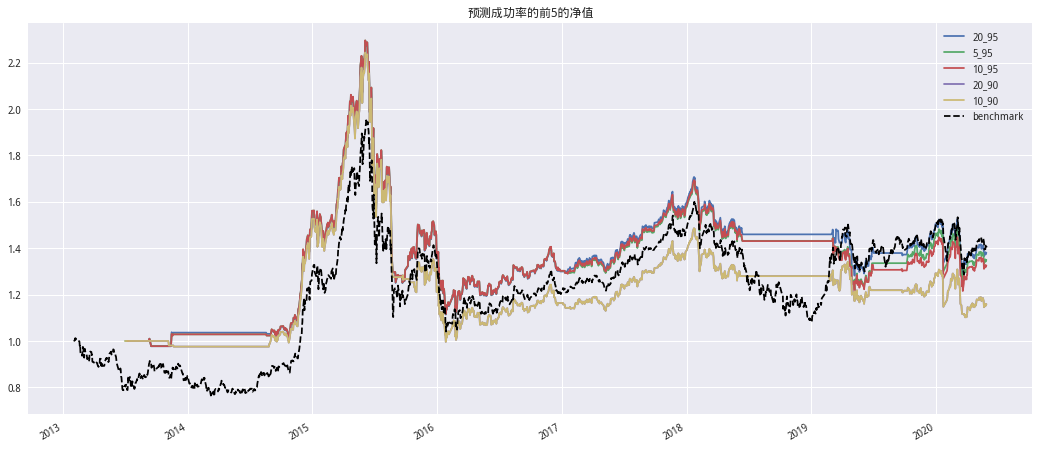

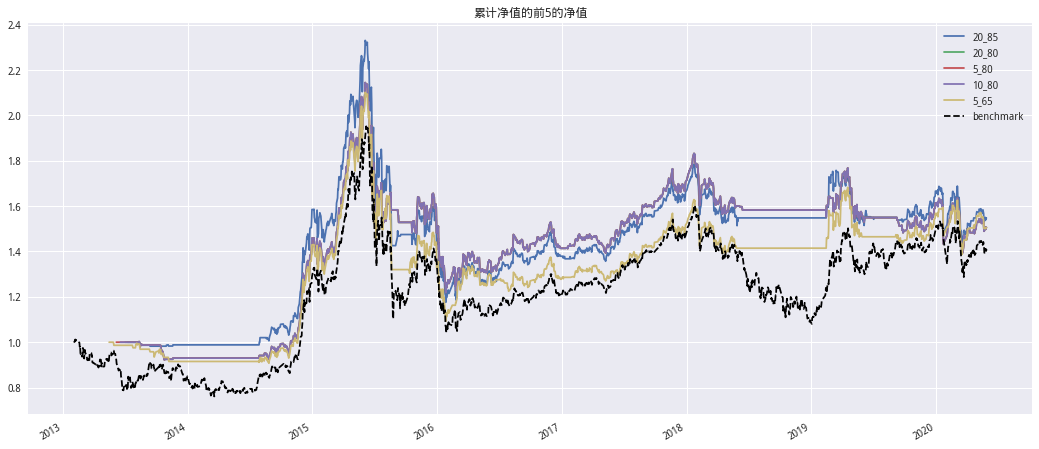

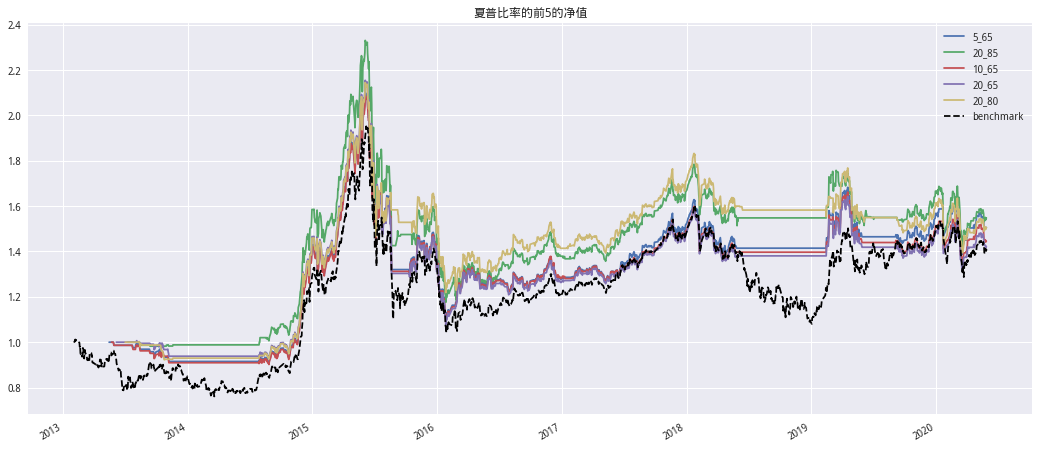

In [29]:
# 查看预测成功概率前五的净值情况
flag = awm.Flag_df
flag = flag.apply(lambda x:np.maximum(x,0))
next_ret = HS300_data['close'].pct_change().shift(-1)

# 计算净值
cum = (1 + flag.mul(next_ret,axis=0)).cumprod()

volatility = cum.std() * np.sqrt(244) # 波动率
annual_ret_rate = np.power(cum.iloc[-2],244 / len(cum))-1 # 年化收益
sharpe = annual_ret_rate / volatility # 夏普


# 预测成功率最高的5组
top_5_p = top_5.index.tolist()
# 累计净值最高的5组
top_5_c = cum.iloc[-2].sort_values(ascending=False).head().index.tolist()
# 夏普最高的5组
top_5_s = sharpe.sort_values(ascending=False).head().index.tolist()

plot_cum(flag,HS300_data['close'],top_5_p,'预测成功率的前5的净值')
plot_cum(flag,HS300_data['close'],top_5_c,'累计净值的前5的净值')
plot_cum(flag,HS300_data['close'],top_5_s,'夏普比率的前5的净值')

查看夏普最大的持仓标记点(绿色填充部分为有持仓的部分)

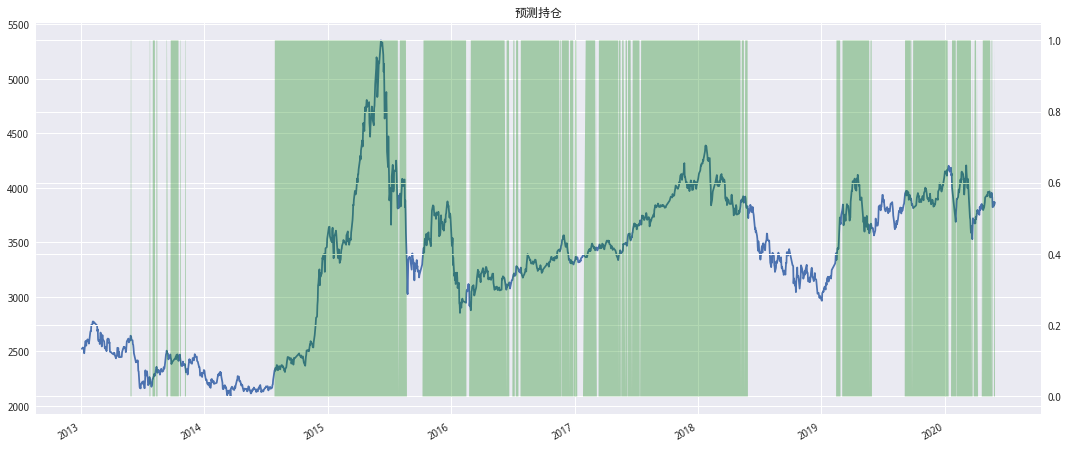

In [30]:
mpl.rcParams['font.family']='serif'
mask = flag.loc[:,top_5_s[0]]
HS300_data['close'].plot(figsize=(18,8),title='预测持仓')

plt.twinx()
plt.fill_between(mask.index, 0, mask.values, facecolor='green', alpha=0.3)

# 三、HS300日涨跌预测——小波降噪
与二中相比，这里增加了对输入序列的小波处理(分解、降噪和重构)。对HS300日涨跌的预测效果，汇总在res_pwsvm_pred中。

In [31]:
awm1 = AnalysisWaveletModel(HS300_data,[5,10,20],range(15,100+1,5),'db4','symmetric','sqtwolog',True) # 'symmetric'
awm1.iterations_params()

模型训练中: 100%|██████████| 54/54 [07:17<00:00,  8.43s/it]


检验不同时间窗情况下支持向量机的预测效果是否能够稳定的超过50%

In [32]:
awm1.T_Value()

't-statistic:5.522676335339947,p_value:1.0286412581539622e-06'

预测成功率前五的参数情况

In [33]:
# 胜率最大的前五
res_df = awm1.res_svm_pred
res_df.index = res_df['M'].astype(str) + '_' + res_df['训练窗宽'].astype(str)
top_5 = res_df.sort_values('成功概率',ascending=False).head()
top_5_list = top_5.index.tolist()

top_5

,M,训练窗宽,总预测次数,成功次数,成功概率,上涨预测成功率,下跌预测成功概率
20_95,20,95,1684,887,0.526722,0.685941,0.351621
5_95,5,95,1699,894,0.526192,0.675676,0.362515
10_95,10,95,1694,888,0.524203,0.679458,0.35396
20_90,20,90,1689,880,0.521018,0.662528,0.364882
10_90,10,90,1699,884,0.520306,0.661036,0.366215


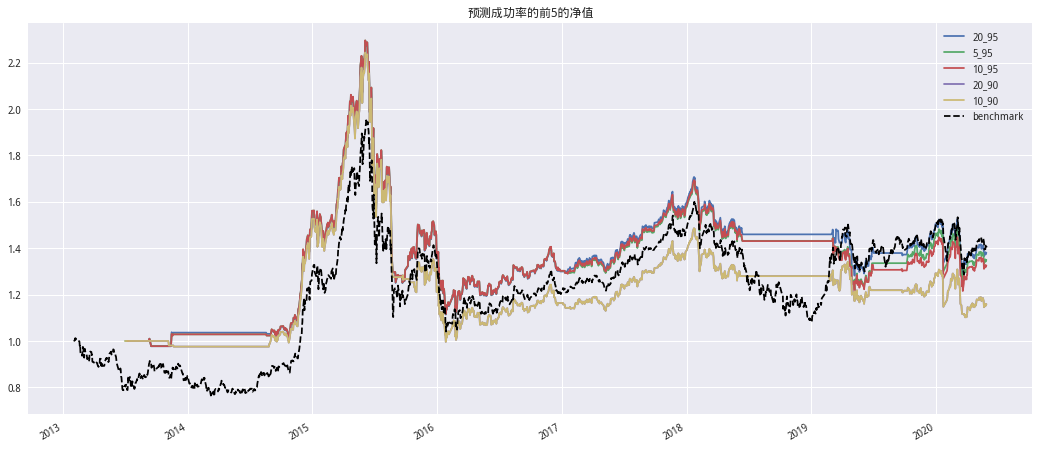

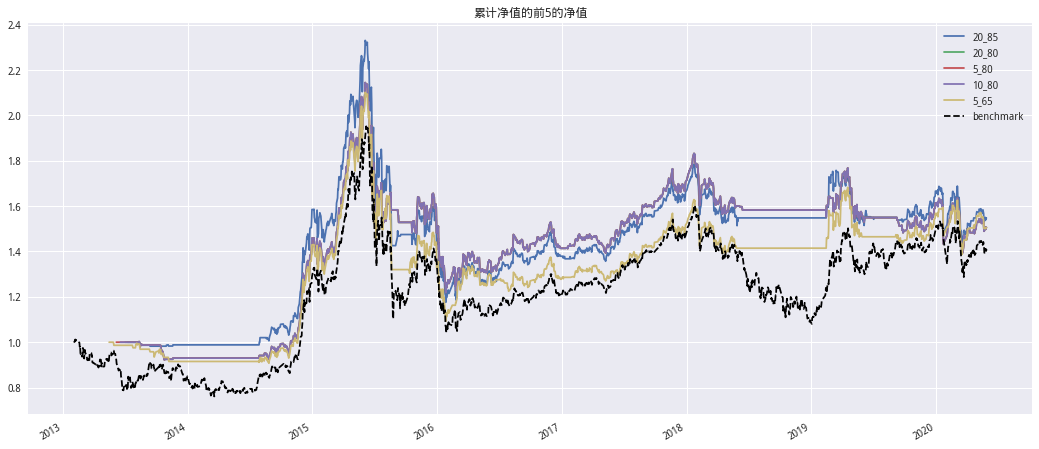

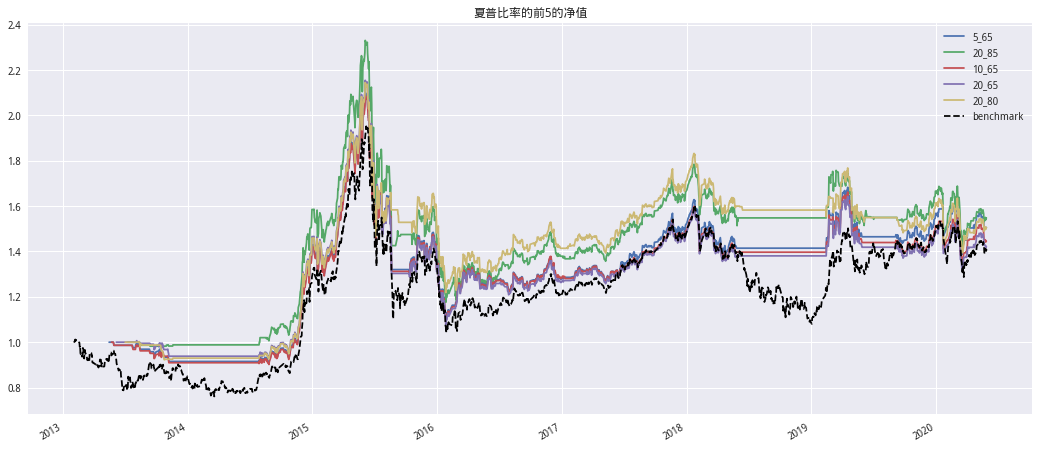

In [34]:
# 查看预测成功概率前五的净值情况
flag = awm1.Flag_df
flag = flag.apply(lambda x:np.maximum(x,0))
next_ret = HS300_data['close'].pct_change().shift(-1)

# 计算净值
cum = (1 + flag.mul(next_ret,axis=0)).cumprod()

volatility = cum.std() * np.sqrt(244) # 波动率
annual_ret_rate = np.power(cum.iloc[-2],244 / len(cum))-1 # 年化收益
sharpe = annual_ret_rate / volatility # 夏普


# 预测成功率最高的5组
top_5_p = top_5.index.tolist()
# 累计净值最高的5组
top_5_c = cum.iloc[-2].sort_values(ascending=False).head().index.tolist()
# 夏普最高的5组
top_5_s = sharpe.sort_values(ascending=False).head().index.tolist()

plot_cum(flag,HS300_data['close'],top_5_p,'预测成功率的前5的净值')
plot_cum(flag,HS300_data['close'],top_5_c,'累计净值的前5的净值')
plot_cum(flag,HS300_data['close'],top_5_s,'夏普比率的前5的净值')

查看预测成功概率最大的持仓标记点(红点为持仓标记点)

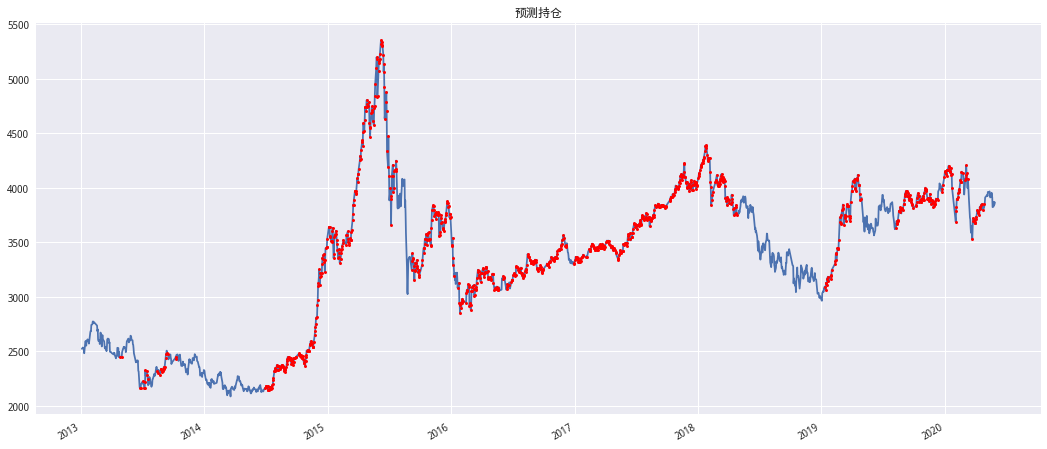

In [35]:
# 持仓标记
mpl.rcParams['font.family'] = 'serif'
mask = flag.loc[:, top_5_s[0]]
mask = mask.reset_index(drop=True)
mask = mask[mask == 1]

HS300_data['close'].plot(
    figsize=(18, 8),
    title='预测持仓',
    markevery=mask.index.tolist(),
    marker='o',
    mfc='red',
    ms=3,
    mec='red')

小波处理对于预测结果的提升效果不显著，因为二与三中的HS300预测结果类似，没有显著差别。

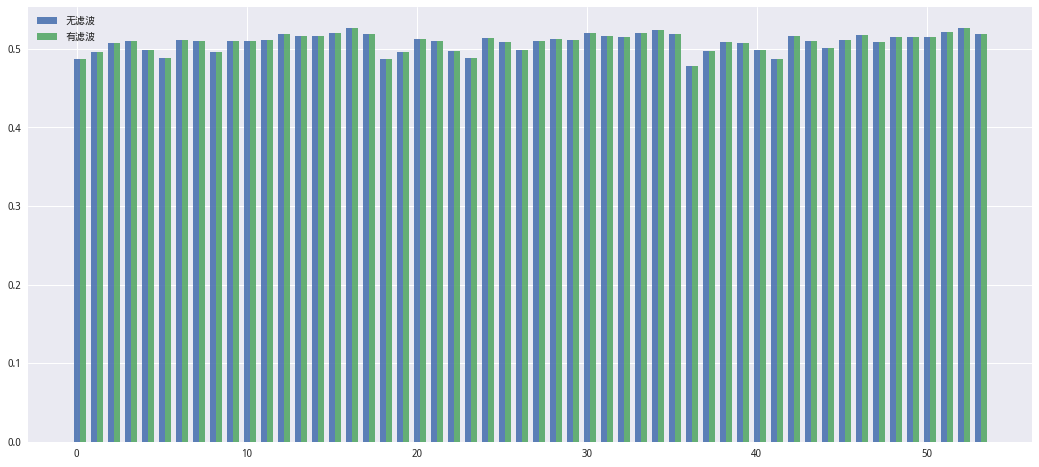

In [36]:
plt.figure(figsize=(18,8))
n = len(awm1.res_svm_pred)
X = np.arange(n)

mpl.rcParams['font.family']='serif'
Y1 = awm.res_svm_pred['成功概率'].values
Y2 = awm1.res_svm_pred['成功概率'].values
plt.bar(X, Y1, alpha=0.9, width = 0.35,  label='无滤波', lw=1)
plt.bar(X+0.35, Y2, alpha=0.9, width = 0.35, label='有滤波', lw=1)
plt.legend(loc="upper left") 


## 基于小波加svm模型进行回测分析

与研究直接模拟的结果差不多 没有一个能打的 为什么预测成功率高但是回测结果如此差？

In [4]:
#1 设定回测的 策略id
pa = parameter_analysis('f2b8666004f9f7c54089b881f7eff6a8')

In [5]:
#2 运行回测
pa.get_backtest_data(file_name = 'results_svm.pkl',  # 保存回测结果的Pickle文件名
                          running_max = 2,      # 同时回测的最大个数,可以通过积分商城兑换
                          benchmark_id = None,   # 基准的回测ID,注意是回测ID而不是策略ID,为None时为策略中使用的基准
                          start_date = '2014-01-01', #回测开始时间
                          end_date = '2020-05-31',   #回测结束时间
                          frequency = 'day',         #回测频率,支持 day, minute, tick 
                          initial_cash = '2000000',  #初始资金
                          param_names = ['M','N'],  #变量名称
                          param_values = [(5,),tuple(range(30,91,5))],  # 变量对应的参数
                          python_version = 3,   # 回测python版本
                          use_credit = True     # 是否允许消耗积分继续回测
                          )

【已完成|运行中|待运行】: [0|0|13]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [0|2|11]. [1|1|11]. [1|2|10]. [1|2|10]. [1|2|10]. [1|2|10]. [1|2|10]. [1|2|10]. [1|2|10]. [2|1|10]. [已用0.082时,尚余0.453时,请不要关闭浏览器]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [2|2|9]. [3|1|9]. [3|2|8]. [3|2|8]. [3|2|8]. [

In [6]:
#3 数据读取
pa.read_backtest_data('results_svm.pkl')

In [7]:
#4 查看回测结果指标
pa.evaluations_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12
M,5,5,5,5,5,5,5,5,5,5,5,5,5
N,30,35,40,45,50,55,60,65,70,75,80,85,90
__version,101,101,101,101,101,101,101,101,101,101,101,101,101
algorithm_return,0.296943,-0.0291966,0.173858,0.434301,0.487472,0.272195,0.158365,0.436029,0.107212,0.0838841,0.441586,0.360952,0.202684
algorithm_volatility,0.186656,0.204275,0.190802,0.193829,0.189425,0.198094,0.20357,0.212711,0.219346,0.218904,0.214333,0.217222,0.220405
alpha,-0.023704,-0.0747053,-0.0405674,-0.0087534,-0.00135994,-0.0292989,-0.0464032,-0.0132163,-0.0580846,-0.0615003,-0.0127157,-0.0237408,-0.0450468
annual_algo_return,0.0425208,-0.00473432,0.0260043,0.0594648,0.0656591,0.039309,0.0238234,0.0596691,0.0164446,0.0129841,0.0603247,0.0505953,0.0299984
annual_bm_return,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166
avg_excess_return,-0.000107548,-0.000299045,-0.00017048,-4.78106e-05,-2.18648e-05,-0.000123294,-0.000187459,-5.5756e-05,-0.000225272,-0.000239291,-5.2701e-05,-9.38021e-05,-0.000174045
avg_position_days,949,946,948,958,950,1003,1035,1044,1074,NaN,1092,1090,1089


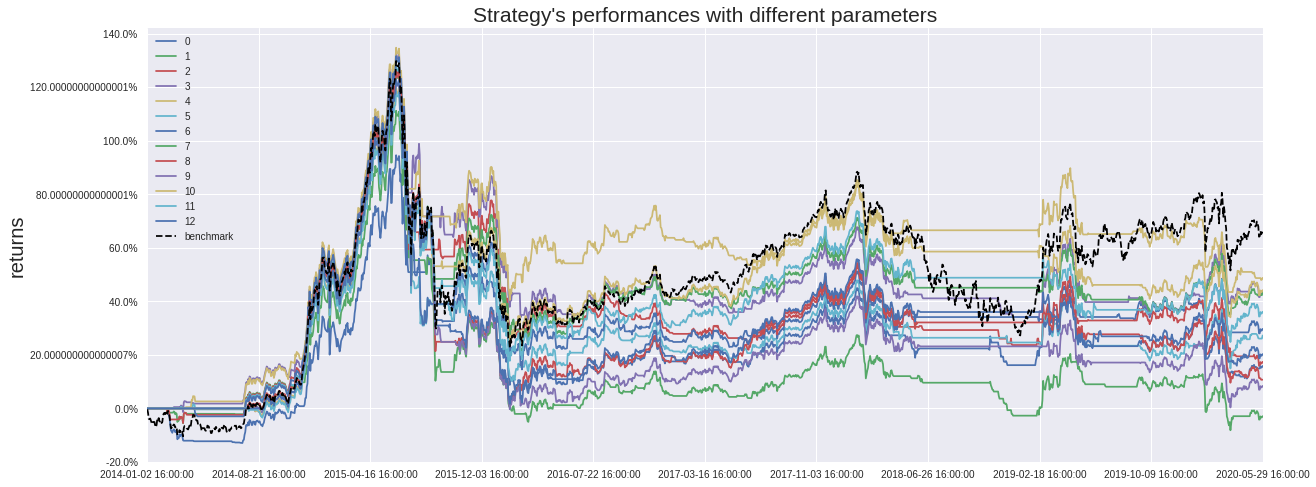

In [8]:
#5 回报率折线图    
pa.plot_returns()

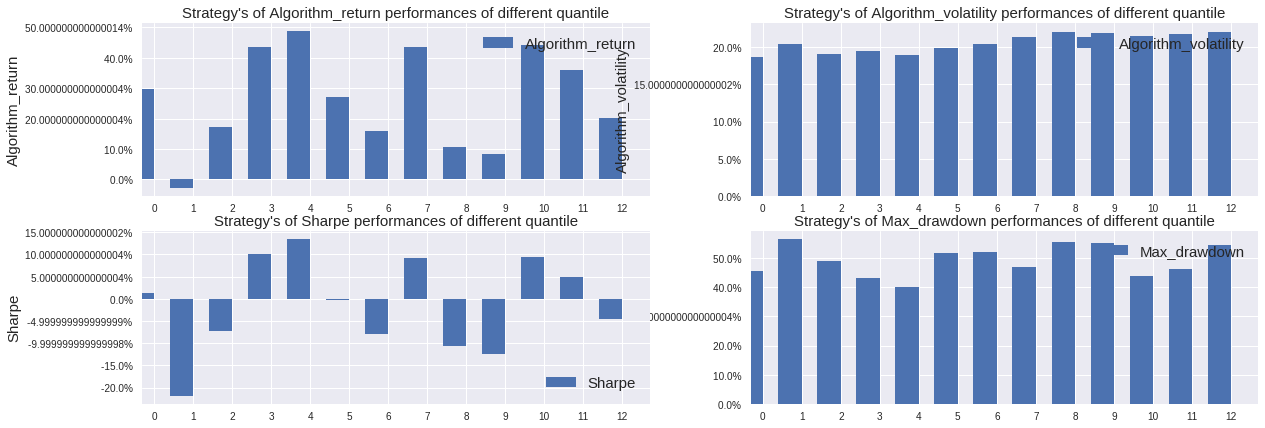

In [9]:
#6 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
pa.get_eval4_bar()

# 四、希尔伯特周期

In [6]:
def GetSingal(time_ser:pd.Series,window:int)->int:
    
    # 对昨日收盘价去噪
    denoised_index = wave_transform(time_ser,'db4','symmetric',4,'sqtwolog',3,4)

    diff_index = denoised_index.diff()
    diff_index = diff_index.dropna()

    # 希尔伯特周期 滚动防止 前视偏差 
    hilbert = diff_index.rolling(window).apply(lambda x:fftpack.hilbert(x)[-1],raw=False)

    # 信号化
    return np.maximum(np.sign(hilbert),0)[-1]

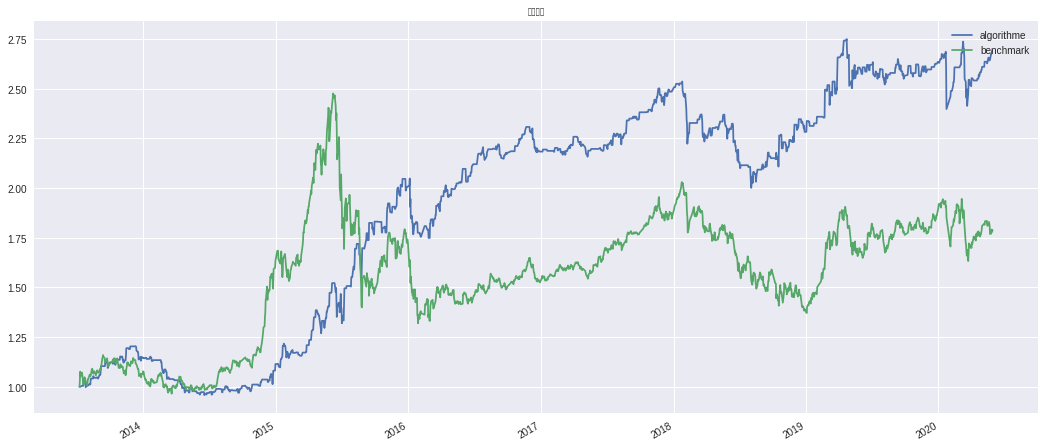

In [11]:
# 获取持仓标记
sign_hilbert = HS300_data['close'].rolling(120).apply(
    GetSingal, kwargs={'window': 20}, raw=False)

sign_hilbert = sign_hilbert.dropna()

slice_df = HS300_data.reindex(sign_hilbert.index)
# 收益
next_ret = (slice_df['close'] / slice_df['pre_close'] - 1).shift(-1)

(1 + sign_hilbert * next_ret).cumprod().plot(figsize=(18, 8), title='净值情况')

(slice_df['close'] / slice_df['close'][0]).plot()
plt.legend(['algorithme', 'benchmark'], loc='upper right')


## 基于希尔伯特周期的信号进行回测

基于上述预测结果中的最好预测结果，将其转换为一个择时策略。具体如下：

1. 预测为1时持仓/开仓
2. 预测为0时平仓/空仓

在这里选择M为滚动计算期。

**结论：一个能打的都没有**

In [130]:
#1 设定回测的 策略id 
pa = parameter_analysis('cbd885c69fa1d18a13e7194d2441f8b8')

In [ ]:
#2 运行回测
pa.get_backtest_data(file_name = 'results_hilbert.pkl',  # 保存回测结果的Pickle文件名
                          running_max = 2,      # 同时回测的最大个数,可以通过积分商城兑换
                          benchmark_id = None,   # 基准的回测ID,注意是回测ID而不是策略ID,为None时为策略中使用的基准
                          start_date = '2014-01-01', #回测开始时间
                          end_date = '2020-05-31',   #回测结束时间
                          frequency = 'day',         #回测频率,支持 day, minute, tick 
                          initial_cash = '2000000',  #初始资金
                          param_names = ['N'],  #变量名称
                          param_values = [range(10,101,10)],  #变量对应的参数
                          python_version = 3,   # 回测python版本
                          use_credit = True     # 是否允许消耗积分继续回测
                          )

In [ ]:
#3 数据读取
pa.read_backtest_data('results_hilbert.pkl')

In [300]:
#4 查看回测结果指标
pa.evaluations_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12
N,50,70,90,110,130,150,170,190,210,230,250,270,290
__version,101,101,101,101,101,101,101,101,101,101,101,101,101
algorithm_return,0.327563,0.291612,0.831253,0.195073,0.211342,0.0292128,0.135445,-0.135542,0.0800705,-0.0198787,0.178536,-0.101422,-0.167867
algorithm_volatility,0.17773,0.191697,0.186078,0.179583,0.179747,0.188753,0.188476,0.188478,0.182243,0.186736,0.188012,0.186955,0.192466
alpha,-0.0183435,-0.0252944,0.0360178,-0.035487,-0.0333487,-0.0613724,-0.0457823,-0.0898872,-0.0530236,-0.0693963,-0.0400674,-0.0838538,-0.0971158
annual_algo_return,0.0464241,0.0418333,0.101743,0.0289518,0.0311823,0.00462215,0.0205518,-0.0230568,0.0124125,-0.00321055,0.0266581,-0.0169814,-0.0290015
annual_bm_return,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166,0.0845166
avg_excess_return,-9.20479e-05,-0.000111473,0.000115575,-0.000156138,-0.000147982,-0.000253163,-0.000192234,-0.000369528,-0.000224361,-0.000287103,-0.000170868,-0.000345986,-0.000397716
avg_position_days,767,745,757,756,758,750,753,755,NaN,768,765,786,776
avg_trade_return,0.00156081,0.00157363,0.00238358,0.00140264,0.00136851,0.000884783,0.00116529,0.000424931,NaN,0.000838961,0.00131896,0.00055418,0.000347771


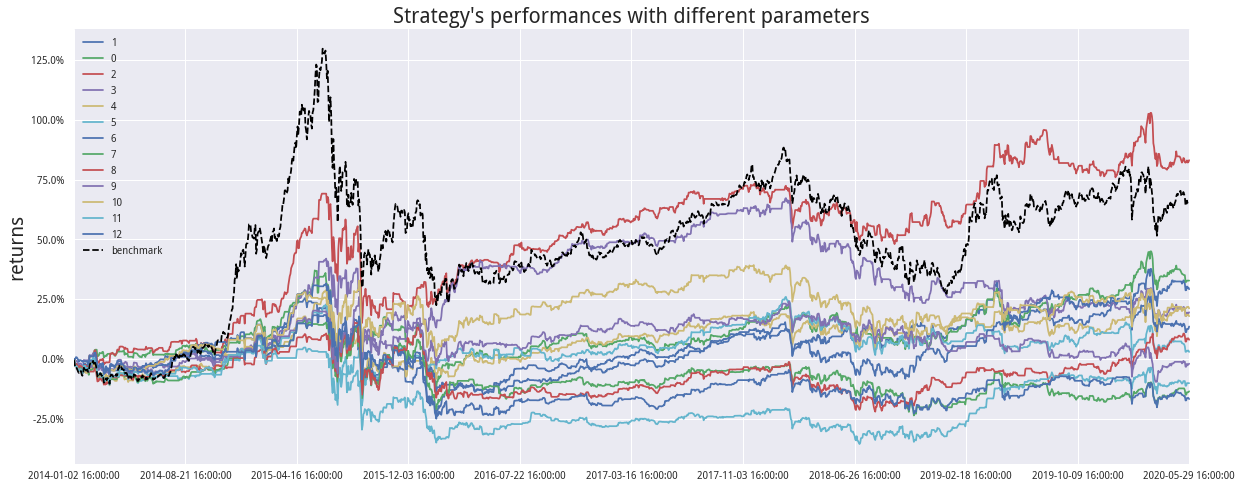

In [301]:
#5 回报率折线图    
pa.plot_returns()

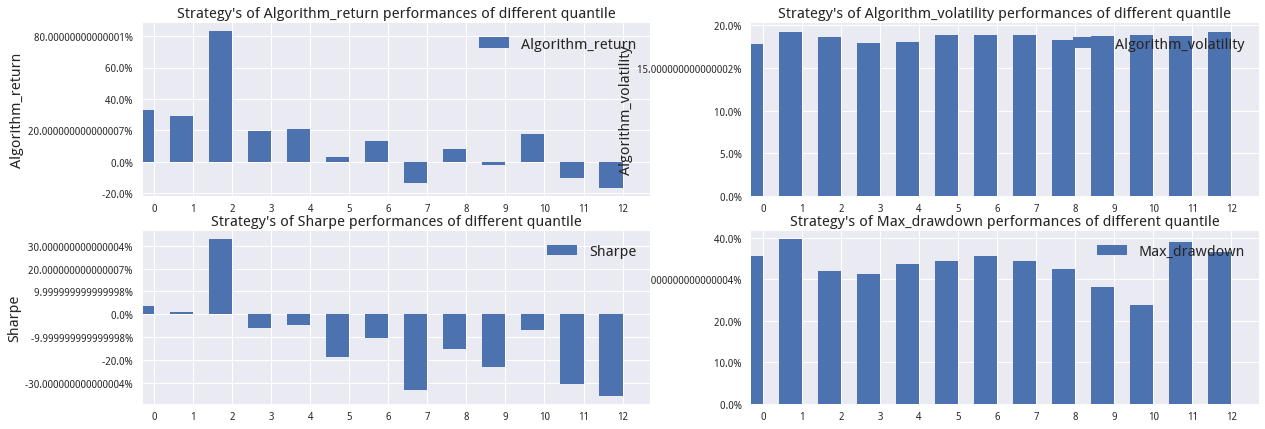

In [302]:
#6 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
# get_eval4_bar(self, sort_by=[])
pa.get_eval4_bar()